# Лабораторная работа №3
*Задание выполнил* **Чащин Артем Максимович**

*Курс:* **3**, *группа:* **МФТИ-1**

**[Telegram](https://t.me/artemchashchin)**

## Оглавление
* [Импорт данных](#import)
* [Визуализация выборки](#visual)
* [Разложение ряда на компоненты](#decomposing)
* [Мультипликативная и аддитивная модели временного ряда](#models)
* [Проверка ряда на стационарность](#checkup)
* [Автокорреляция и коррелограмма](#autocor)



In [140]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import numpy as np
import os
from torchvision.io import read_image
from PIL import Image
import matplotlib.pyplot as plt

In [141]:
from dotenv import load_dotenv
load_dotenv(dotenv_path='./.env')

True

In [162]:
file_path = os.getenv('PATH_TO_DATA')

annotations_file = os.path.join(os.sep, file_path, 'train_labels.csv')
img_train_dir = os.path.join(os.sep, file_path, 'images/images/train')
img_test_dir = os.path.join(os.sep, file_path, 'images/images/test')
new_annotations_file = os.path.join(os.sep, file_path, 'train_labels_resized.csv')
new_img_train_dir = os.path.join(os.sep, file_path, 'images/images/train_resized')
img_test_dir_resized = os.path.join(os.sep, file_path, 'images/images/test_resized')

In [143]:
class CatsDataSet(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, has_labels=True):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.has_labels = has_labels

        if self.has_labels:
            self.img_labels = pd.read_csv(annotations_file)
        else:
            self.image_files = os.listdir(img_dir)

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        if self.has_labels:
            listdir = os.listdir(self.img_dir)
            file_name = listdir[idx]
            img_path = os.path.join(self.img_dir, file_name)

            row = self.img_labels[self.img_labels['file_name'] == file_name]
            label = torch.tensor(row.iloc[0, :-1].values.astype(float))
        else:
            img_path = os.path.join(self.img_dir, self.image_files[idx])
            label = None

        image = read_image(img_path)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        if self.has_labels:
          return image.float(), label.float()
        else:
          return image.float(), torch.empty(()).float()

In [144]:
from typing import Union
import pandas as pd

def resize_train_data(
    img_train_dir: str,
    annotations_file: str
) -> None:
    """
    Изменяет размер изображений в папке `img_train_dir` и соответствующие аннотации
    в файле `annotations_file` на размер 256x256 пикселей. Измененные изображения и
    обновленные аннотации сохраняются в соответствующие папки и файлы.

    Аргументы:
    - img_train_dir (str): Путь к папке с обучающими изображениями.
    - annotations_file (str): Путь к файлу с аннотациями.

    Возвращаемое значение:
    - None

    Исключения:
    - ValueError: Возникает, если указанный файл аннотаций недействителен или пустой.
                  Также может возникнуть, если не удалось создать папку для измененных изображений.
    - OSError: Возникает, если не удалось открыть или сохранить изображение.
    """
    try:
        df = pd.read_csv(annotations_file)
    except pd.errors.EmptyDataError:
        raise ValueError("Invalid annotations file or empty dataframe")

    folder_path = os.getenv("TRAIN_RESIZED")

    for filename in os.listdir(img_train_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            file_path = os.path.join(os.sep ,img_train_dir, filename)

            try:
                image = Image.open(file_path)
            except OSError:
                print(f"Failed to open image {filename}. Skipping...")
                continue

            image_size = image.size

            resized_image = image.resize((256, 256))
            resized_image_size = resized_image.size

            x_change = resized_image_size[0] / image_size[0]
            y_change = resized_image_size[1] / image_size[1]

            row = df[df['file_name'] == filename]

            for column_name in row.columns.tolist():
                if column_name.endswith('x'):
                    df.loc[df['file_name'] == filename, column_name] *= x_change
                elif column_name.endswith('y'):
                    df.loc[df['file_name'] == filename, column_name] *= y_change

            try:
                # Сохранение измененного изображения
                resized_image.save(os.path.join(os.path.join(os.getenv("PATH_TO_DATA"), "images/images/train_resized"), filename))
            except OSError:
                print(f"Failed to save resized image {filename}. Skipping...")

    try:
        df.to_csv(os.path.join(os.getenv("PATH_TO_DATA"), 'train_labels_resized.csv'), index=False)
    except OSError:
        print("Failed to save resized annotations file")

In [145]:
from typing import Dict, List, Union
import os
from PIL import Image


def resize_test_data(img_train_dir: str) -> Dict[str, List[Union[float, float]]]:
    """
    Изменяет размер тестовых изображений в папке `img_train_dir` на размер 256x256 пикселей
    и возвращает словарь с коэффициентами изменения размера для каждого изображения.

    Аргументы:
    - img_train_dir (str): Путь к папке с тестовыми изображениями.

    Возвращаемое значение:
    - dict_koefs (Dict[str, List[Union[float, float]]]): Словарь, где ключами являются имена
      изображений, а значениями - списки коэффициентов изменения размера (x_change, y_change).

    Исключения:
    - FileNotFoundError: Возникает, если указанная папка с тестовыми изображениями не существует.
    - OSError: Возникает, если не удалось открыть изображение.
    """
    if not os.path.isdir(img_train_dir):
        raise FileNotFoundError(f"Test image directory not found: {img_train_dir}")

    folder_path = os.path.join(os.getenv("PATH_TO_DATA"), 'images/images/test_resized')

    dict_koefs: Dict[str, List[Union[float, float]]] = {}

    for filename in os.listdir(img_train_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Полный путь к файлу
            file_path = os.path.join(img_train_dir, filename)

            try:
                # Открытие изображения
                image = Image.open(file_path)
                image_size = image.size

                # Изменение размера изображения до 256x256
                resized_image = image.resize((256, 256))
                resized_image_size = resized_image.size

                x_change = resized_image_size[0] / image_size[0]
                y_change = resized_image_size[1] / image_size[1]

                dict_koefs[filename] = [x_change, y_change]
            
            except OSError:
                print(f"Failed to open image {filename}. Skipping...")
                continue

    return dict_koefs

In [146]:
# resize_train_data(img_train_dir, annotations_file)

In [168]:
koefs = resize_test_data(img_test_dir)

In [148]:
import os
import random
from typing import List
from sklearn.model_selection import train_test_split


def split_train_data() -> None:
    """
    Разделяет тренировочные изображения на тренировочную и валидационную выборки.
    Перемещает файлы в соответствующие папки.

    Возвращаемое значение:
    - None

    Исключения:
    - FileNotFoundError: Возникает, если путь к папке с тренировочными изображениями недействителен.
    - OSError: Возникает, если не удалось переместить файлы.
    """
    img_train_dir = os.path.join(os.getenv("PATH_TO_DATA"), 'images/images/train_resized')

    if not os.path.isdir(img_train_dir):
        raise FileNotFoundError(f"Train image directory not found: {img_train_dir}")

    file_names = os.listdir(img_train_dir)
    random.shuffle(file_names)

    train_files, val_files = train_test_split(file_names, test_size=0.2, random_state=42)

    train_folder = img_train_dir
    val_folder = os.path.join(os.getenv("PATH_TO_DATA"), 'images/images/val_resized')

    move_files(train_files, img_train_dir, train_folder)
    move_files(val_files, img_train_dir, val_folder)


def move_files(file_names: List[str], src_folder: str, dst_folder: str) -> None:
    """
    Перемещает файлы из списка `file_names` из папки `src_folder` в папку `dst_folder`.

    Аргументы:
    - file_names (List[str]): Список имен файлов для перемещения.
    - src_folder (str): Путь к исходной папке, откуда перемещаются файлы.
    - dst_folder (str): Путь к целевой папке, куда перемещаются файлы.

    Возвращаемое значение:
    - None

    Исключения:
    - OSError: Возникает, если не удалось переместить файлы.
    """
    for file_name in file_names:
        src = os.path.join(src_folder, file_name)
        dst = os.path.join(dst_folder, file_name)

        try:
            os.rename(src, dst)
        except OSError:
            print(f"Failed to move file: {file_name}")

In [149]:
# split_train_data()

In [150]:
from typing import Dict
import pandas as pd


def mult_preds(preds_df: pd.DataFrame, dict_koefs: Dict[str, List[float]]) -> pd.DataFrame:
    """
    Возвращает предсказания `preds_df` с координатами, приведенными к начальным размерам изображений,
    используя коэффициенты изменения размера из `dict_koefs`.

    Аргументы:
    - preds_df (pd.DataFrame): DataFrame с предсказаниями, содержащий столбцы 'file_name', 'x1', 'y1', 'x2', 'y2', ...
    - dict_koefs (Dict[str, List[float]]): Словарь, где ключами являются имена файлов, а значениями - списки коэффициентов
      изменения размера (x_change, y_change).

    Возвращаемое значение:
    - preds_df (pd.DataFrame): DataFrame с предсказаниями, в котором координаты приведены к начальным размерам изображений.

    Исключения:
    - KeyError: Возникает, если имя файла в предсказаниях не найдено в словаре `dict_koefs`.
    """
    for index, row in preds_df.iterrows():
        file_name = row['file_name']
        if file_name not in dict_koefs:
            raise KeyError(f"File name not found in dict_koefs: {file_name}")

        x_change = dict_koefs[file_name][0]
        y_change = dict_koefs[file_name][1]

        for column_name, value in row.iteritems():
            if column_name.endswith('x'):
                preds_df.at[index, column_name] = value / x_change
            elif column_name.endswith('y'):
                preds_df.at[index, column_name] = value / y_change

    return preds_df

In [151]:
from torch import Tensor

def get_val_tensor(img_dir: str, annotations_file: str) -> Tensor:
    """
    Возвращает тензор из точек изображений валидационных данных.

    Аргументы:
    - img_dir (str): Путь к папке с изображениями.
    - annotations_file (str): Путь к файлу с аннотациями.

    Возвращаемое значение:
    - val_tensor (Tensor): Тензор, содержащий точки изображений валидационных данных.

    Исключения:
    - FileNotFoundError: Возникает, если путь к папке с изображениями или путь к файлу с аннотациями недействителен.
    - IndexError: Возникает, если нет соответствующих аннотаций для файла изображения.
    """
    if not os.path.isdir(img_dir):
        raise FileNotFoundError(f"Image directory not found: {img_dir}")

    if not os.path.isfile(annotations_file):
        raise FileNotFoundError(f"Annotations file not found: {annotations_file}")

    df = pd.read_csv(annotations_file)
    listdir = os.listdir(img_dir)
    val_tensor = torch.empty(0, 18)

    for file_name in listdir:
        row = df[df['file_name'] == file_name].iloc[0, :-1]
        row_tensor = torch.tensor(row.values.astype(float))
        val_tensor = torch.cat((val_tensor, row_tensor.unsqueeze(0)), dim=0)

    return val_tensor

In [152]:
import numpy as np

def predict_values(net: torch.nn.Module, img_dir: str) -> Tensor:
    """
    Генерирует предсказания с использованием модели `net` для изображений из `img_dir`.

    Аргументы:
    - net (torch.nn.Module): Модель для генерации предсказаний.
    - img_dir (str): Путь к папке с изображениями.

    Возвращаемое значение:
    - predictions (Tensor): Тензор, содержащий предсказания модели для всех изображений.

    Исключения:
    - FileNotFoundError: Возникает, если путь к папке с изображениями недействителен.
    """
    if not os.path.isdir(img_dir):
        raise FileNotFoundError(f"Image directory not found: {img_dir}")

    # Загрузка тестового датасета с использованием класса CatsDataSet
    test_dataset = CatsDataSet(
        annotations_file=None,
        img_dir=img_dir,
        has_labels=False
    )

    # Создание дата-лоадера для тестового датасета
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

    # Перевод модели в режим оценки (evaluation mode)
    net.eval()

    # Цикл по тестовым данным
    predictions = []
    for inputs, _ in test_dataloader:
        # Передача данных через модель для получения предсказаний
        # inputs = inputs.to('cuda')
        outputs = net(inputs)
        predictions.append(outputs.detach().numpy())

    # Объединение предсказаний в один массив
    predictions = np.concatenate(predictions, axis=0)

    # Вывод предсказаний
    return torch.tensor(predictions)

In [153]:
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader 
from tqdm import tqdm

def training(net: torch.nn.Module,
             n_epochs: int,
             optimizer: Optimizer,
             scheduler: torch.optim.lr_scheduler._LRScheduler,
             criterion: torch.nn.modules.loss._Loss,
             dataloader: DataLoader) -> float:
    """
    Обучает модель `net` на `n_epochs` эпохах с использованием указанного оптимизатора, расписания и критерия потерь.

    Аргументы:
    - net (torch.nn.Module): Модель для обучения.
    - n_epochs (int): Количество эпох обучения.
    - optimizer (Optimizer): Оптимизатор для обновления параметров модели.
    - scheduler (torch.optim.lr_scheduler._LRScheduler): Расписание для изменения learning rate.
    - criterion (torch.nn.modules.loss._Loss): Критерий потерь для оптимизации модели.
    - dataloader (DataLoader): Загрузчик данных для обучения.

    Возвращаемое значение:
    - avg_val_loss (float): Среднее значение потерь на валидационном наборе данных после каждой эпохи.

    Исключения:
    - FileNotFoundError: Возникает, если путь к файлу с параметрами модели недействителен.
    """
    loss_history = []
    val_loss_history = []
    val_tensor = get_val_tensor(
        os.path.join(os.getenv("PATH_TO_DATA"), 'images/images/val_resized'),
        os.path.join(os.getenv("PATH_TO_DATA"), 'train_labels_resized.csv')
    )

    for i in range(n_epochs):
        progress_bar = tqdm(dataloader, desc=f'Epoch {i+1}/{n_epochs}', unit='batch')
        for x_batch, y_batch in progress_bar:
            # x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')

            predictions = net(x_batch)
            loss = criterion(predictions.squeeze(), y_batch.squeeze())

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            scheduler.step(loss)

            loss_history.append(loss.item())

        file_name = "net_parameters_" + str(i)
        preds = predict_values(
            net,
            os.path.join(os.getenv("PATH_TO_DATA"), 'images/images/val_resized')
        )

        loss_fn = nn.L1Loss()
        l1_loss = loss_fn(val_tensor.squeeze(), preds.squeeze())
        val_loss_history.append(l1_loss.item())

        # Сохранение параметров модели в файл
        try:
            torch.save(net.state_dict(), os.path.join(os.getenv("PATH_TO_DATA"), file_name))
        except FileNotFoundError as e:
            print(f"Failed to save model parameters: {str(e)}")

    plt.figure(figsize=(8, 6))
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)

    avg_val_loss = sum(val_loss_history) / len(val_loss_history)
    return avg_val_loss

In [154]:
import torch.nn as nn


class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()

        layers = [
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(131072, 128),
            nn.ReLU(),
            nn.Linear(128, 18)
        ]

        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

In [155]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [156]:
train_dataset = CatsDataSet(annotations_file=new_annotations_file,
                                   img_dir=new_img_train_dir)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

[I 2024-01-08 01:18:28,576] A new study created in memory with name: no-name-8136f1c2-7a99-4b9e-8b02-419fa0fe9940
Epoch 1/1:   0%|          | 0/900 [00:00<?, ?batch/s]f:\PyTorchTest\venv\lib\site-packages\torch\optim\lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1/1: 100%|██████████| 900/900 [06:18<00:00,  2.38batch/s]


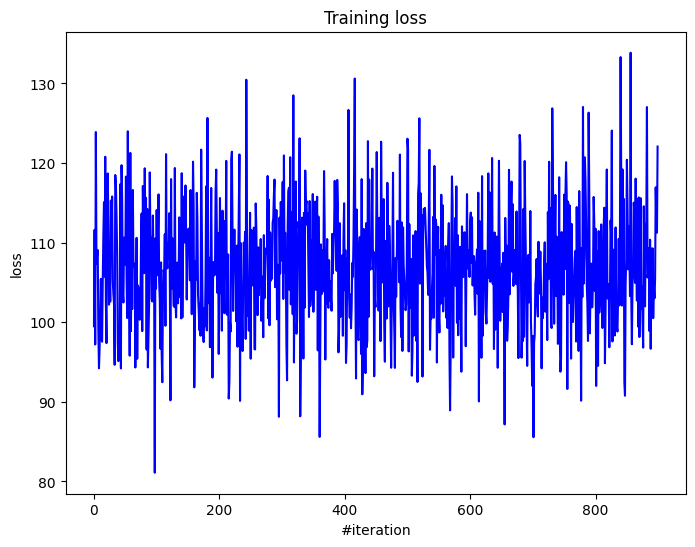

[I 2024-01-08 01:25:14,787] Trial 0 finished with value: 107.58698326308367 and parameters: {'step_size': 6, 'lr': 1.3066886223090469e-06, 'gamma': 0.35091687125836424}. Best is trial 0 with value: 107.58698326308367.


Current loss: 122.068520


Epoch 1/1:   0%|          | 0/900 [00:00<?, ?batch/s]f:\PyTorchTest\venv\lib\site-packages\torch\optim\lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1/1: 100%|██████████| 900/900 [05:48<00:00,  2.58batch/s]


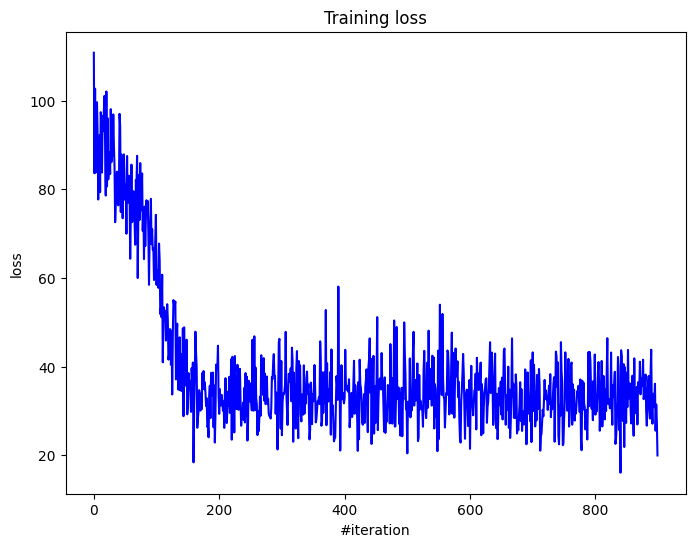

[I 2024-01-08 01:31:31,861] Trial 1 finished with value: 32.04252069269674 and parameters: {'step_size': 6, 'lr': 1.0259919682407095e-05, 'gamma': 0.7521937169717363}. Best is trial 1 with value: 32.04252069269674.


Current loss: 19.987028
{'step_size': 6, 'lr': 1.0259919682407095e-05, 'gamma': 0.7521937169717363}


In [157]:
import optuna
from torch import optim, nn

def objective(trial: optuna.Trial) -> float:
    step_size = trial.suggest_int('step_size', 1, 10)
    lr = trial.suggest_float('lr', 1e-6, 1e-3, log=True)
    gamma = trial.suggest_float('gamma', 0.1, 0.9)
    n_epochs = 1

    net = MyNet()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.L1Loss()
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    dataloader = train_dataloader

    try:
        mean_val_loss = training(net, n_epochs, optimizer, scheduler, criterion, dataloader)
        return mean_val_loss
    except Exception as e:
        # Обработка исключений
        print(f"An error occurred during training: {str(e)}")
        return float('inf')

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2)

best_params = study.best_params
print(best_params)

Epoch 1/1: 100%|██████████| 900/900 [06:03<00:00,  2.47batch/s]


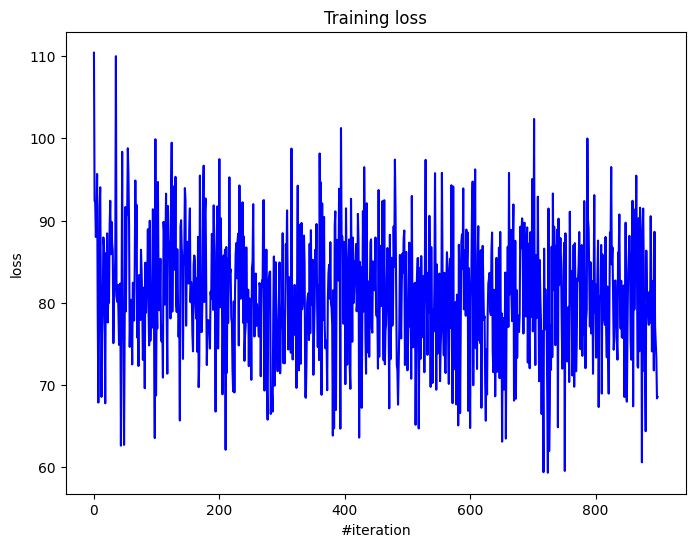

Current loss: 68.535706
79.86993690766465


In [159]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

n_epochs = 1
net = MyNet() 
optimizer = optim.Adam(net.parameters(), lr=1.0259919682407095e-05)
criterion = nn.L1Loss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, threshold=1e-4, cooldown=0, min_lr=0, eps=1e-8, verbose=False)
dataloader = train_dataloader

mean_val_loss = training(net, n_epochs, optimizer,scheduler, criterion, dataloader)
print(mean_val_loss)

In [167]:
preds = predict_values(net, img_test_dir_resized) # предсказываем значения в новых координатах

In [172]:
import pandas as pd
import os

def transform_and_save_preds(preds: pd.DataFrame, dict_koefs: dict) -> None:
    try:
        answer = pd.DataFrame(preds)
        new_column = pd.DataFrame(os.listdir(img_test_dir))
        answer['file_name'] = new_column

        df = pd.read_csv(annotations_file)
        columns = df.columns
        answer.columns = columns
        normal_answer = mult_preds(answer, dict_koefs)

        normal_answer.to_csv('submission.csv', index=False)
    
    except Exception as e:
        print(f"An error occurred: {str(e)}")

In [178]:
transform_and_save_preds(preds, koefs)

<ipython-input-12-1d6eb85d0eed>:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead. 
 for column_name, _ in row.iteritems():
